# Kmeans Clustering


## 1. Do kmeans clustering and show on mds data

In [3]:
import kmeansClustering_functions as kmc
import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
import math


In [4]:

#from pickle file
basic_features_normalized_all_df =  pd.read_pickle('Flow_Features/basic_normalized_flow.pkl')
all_normalized_all_df = pd.read_pickle('Flow_Features/all_normalized_flow.pkl')
all_features_all = pd.read_pickle('Flow_Features/all_features_flow.pkl')

lower_bound = 2
num_clusters = 70

cluster_labels_kmeans_basic , cluster_scores_kmeans_basic= kmc.kmeans_clustering(all_features_all,basic_features_normalized_all_df, lower_bound, num_clusters)
cluster_labels_kmeans_additional, cluster_scores_kmeans_additional = kmc.kmeans_clustering(all_features_all, all_normalized_all_df, lower_bound, num_clusters)


#save the cluster labels to a csv file in the current directory
cluster_labels_kmeans_basic.to_csv('Labels/Kmeans/cluster_labels_kmeans_basic_flow.csv')
#save the cluster scores to a csv file
cluster_scores_kmeans_basic.to_csv('Scores/Kmeans/cluster_scores_kmeans_basic_flow.csv')

#save the cluster labels to a csv file
cluster_labels_kmeans_additional.to_csv('Labels/Kmeans/cluster_labels_kmeans_additional_flow.csv')
#save the cluster scores to a csv file
cluster_scores_kmeans_additional.to_csv('Scores/Kmeans/cluster_scores_kmeans_additional_flow.csv')


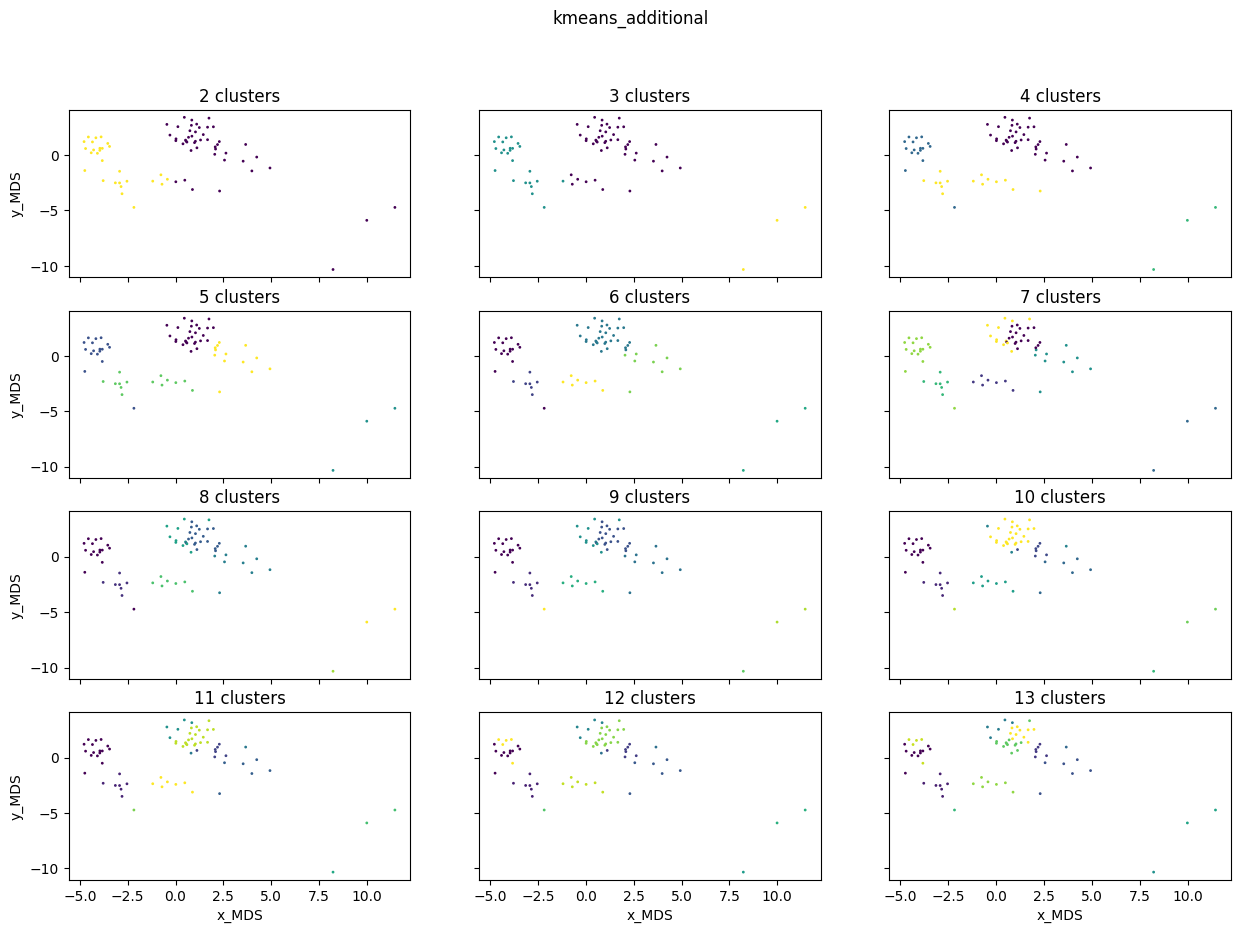

In [5]:
def plot_clusters(number_of_plots, num_columns, lower_bound, mds_representation, cluster_labels, name):
    # plot the clusters
    num_rows = math.ceil(number_of_plots/num_columns) 
    j = 0
    i = 0

    current_cluster = lower_bound
   


    fig, axs = plt.subplots(num_rows, num_columns)
    fig.set_size_inches(15,10)
    fig.suptitle(name)
    while current_cluster < number_of_plots + lower_bound:
        axs[j,i].scatter(mds_representation['x_MDS'] , mds_representation['y_MDS'],s = 1, c=cluster_labels[str(current_cluster) + ' clusters'])
        axs[j,i].set_title(str(current_cluster) + ' clusters')
        #set the height of the subplots to be the same as the width
        #axs[j,i].set_aspect('equal')
        i = i+1
        if(i % 3 ==0):
            j = j+1
            i = 0
        current_cluster = current_cluster + 1

    for ax in axs.flat:
        ax.set(xlabel='x_MDS', ylabel='y_MDS')

    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axs.flat:
        ax.label_outer()

all_mds_all_df = pd.read_pickle('Flow_mds/all_mds_flow.pkl')

plot_clusters(12,3,2, all_mds_all_df, cluster_labels_kmeans_additional, 'kmeans_additional')

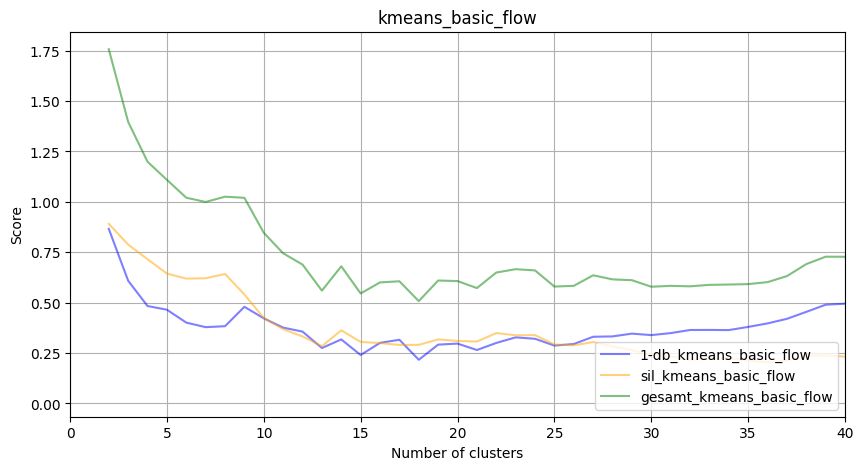

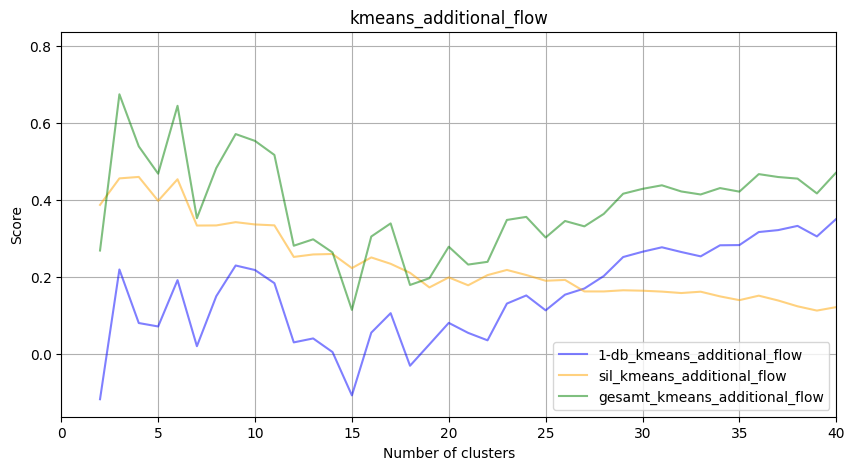

In [6]:
from matplotlib import ticker


def plot_scores(cluster_scores, cluster_option):

    

    fig, ax = plt.subplots(figsize=(10,5))
    ax.plot(cluster_scores['num_clusters'], 1-cluster_scores['davies_bouldin_score'], label='1-db_' + cluster_option, color='blue')
    ax.plot(cluster_scores['num_clusters'], cluster_scores['silhouette_score'], label='sil_' +  cluster_option, color='orange')
    ax.plot(cluster_scores['num_clusters'], -cluster_scores['davies_bouldin_score']+ 1 + cluster_scores['silhouette_score'], label='gesamt_' + cluster_option, color='green')
    ax.grid(True, which='both')
    #reduce x axis to0 to 20
    ax.set_xlim(0,40)

    #only show points not lines
    
      
    ax.set_title(cluster_option)
    ax.set_xlabel('Number of clusters')
    ax.set_ylabel('Score')
    #make graphs semi transparent
    for line in ax.get_lines():
        line.set_alpha(0.5)

    #show the legend in the lower right corner
    ax.legend(loc = 'lower right')
    plt.show()


plot_scores(cluster_scores_kmeans_basic, 'kmeans_basic_flow')
plot_scores(cluster_scores_kmeans_additional, 'kmeans_additional_flow')



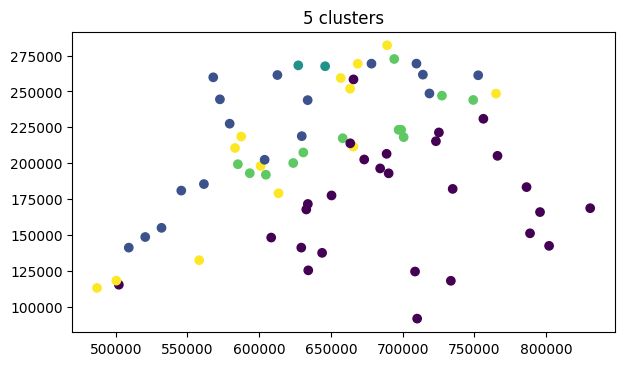

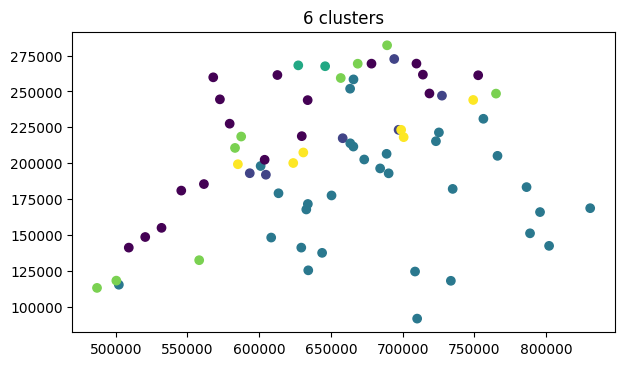

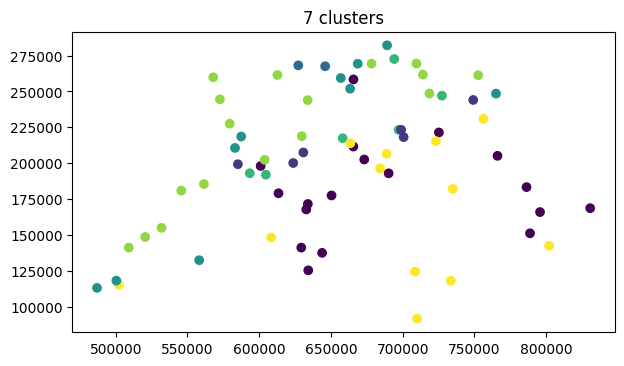

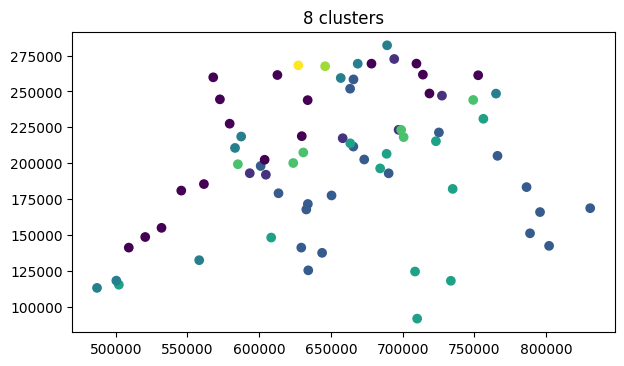

In [7]:
# show clusters on map 
#read in the data
locations_df = pd.read_csv("Data/stations_location.csv", sep=";")

#merge cluster labels with locations_df on Stationsnummer= Station_Nr
def merge_clusterlabels_map(cluster_labels):
    cluster_labels = pd.merge(cluster_labels, locations_df, left_on='Stationsnummer', right_on='Station_Nr')
    return cluster_labels
#plot the clusters with the locations of the stations

def plot_clusters_map( cluster_labels, num_clusters):

    fig, ax = plt.subplots(figsize=(7,5))
    ax.scatter(cluster_labels['From_Node_X'] , cluster_labels['From_Node_Y'], c=cluster_labels[num_clusters + ' clusters'])
    ax.set_title(num_clusters +' clusters')
    ax.set_aspect('equal')
    #print name of each station to the point
    # for i, txt in enumerate(cluster_labels_kmeans_map['Station_Name']):
    #     ax.annotate(txt, (cluster_labels_kmeans_map['From_Node_X'][i], cluster_labels_kmeans_map['From_Node_Y'][i]))
    plt.show()

for i in range(5,9):
    plot_clusters_map(merge_clusterlabels_map(cluster_labels_kmeans_additional), str(i))




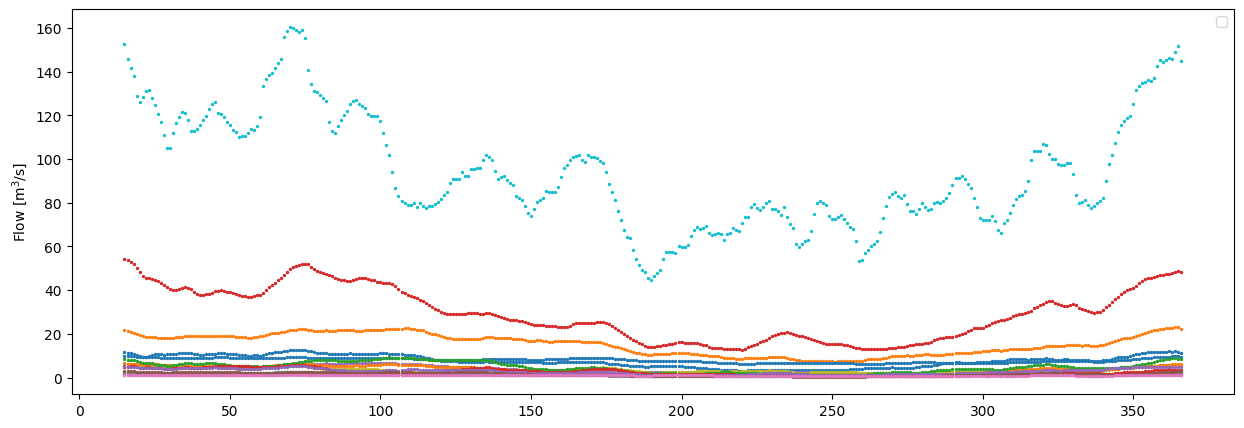

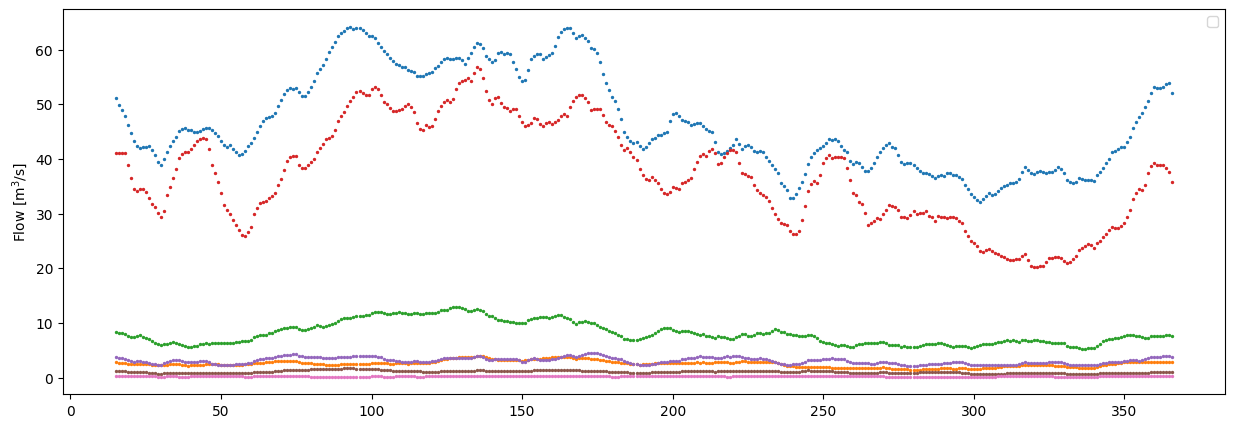

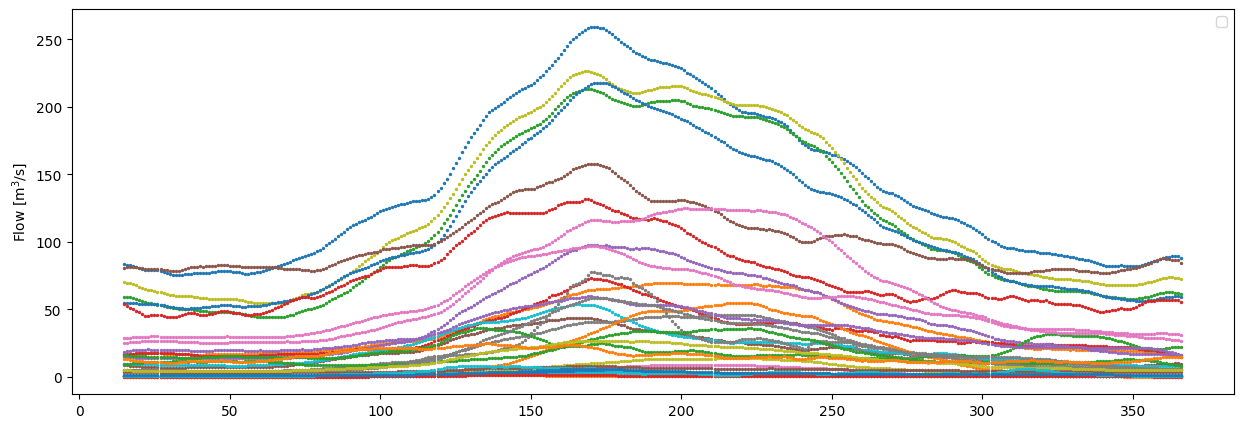

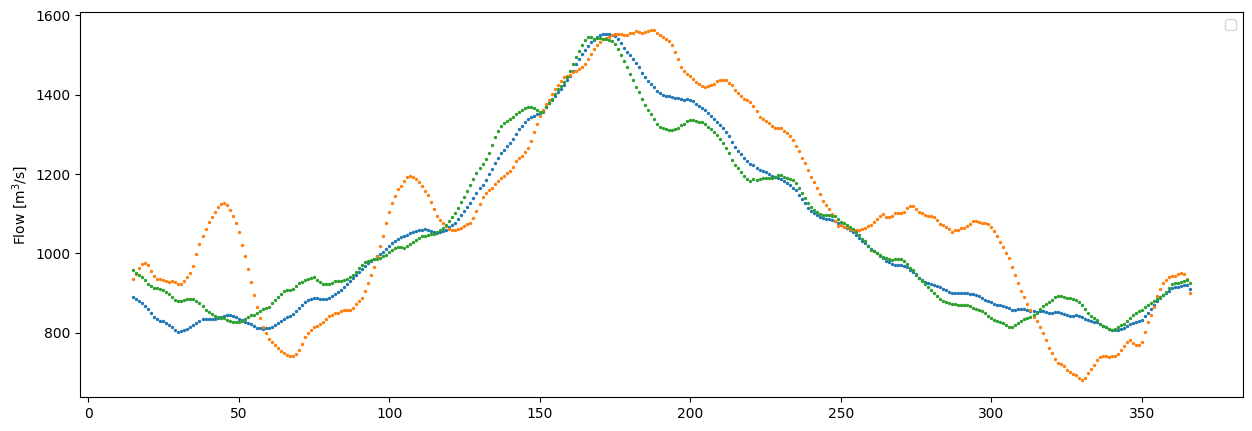

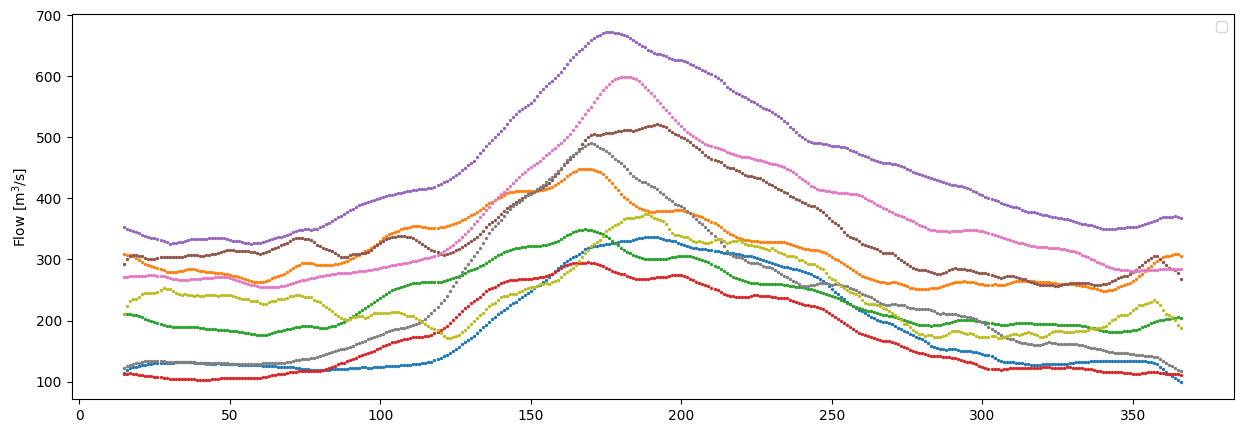

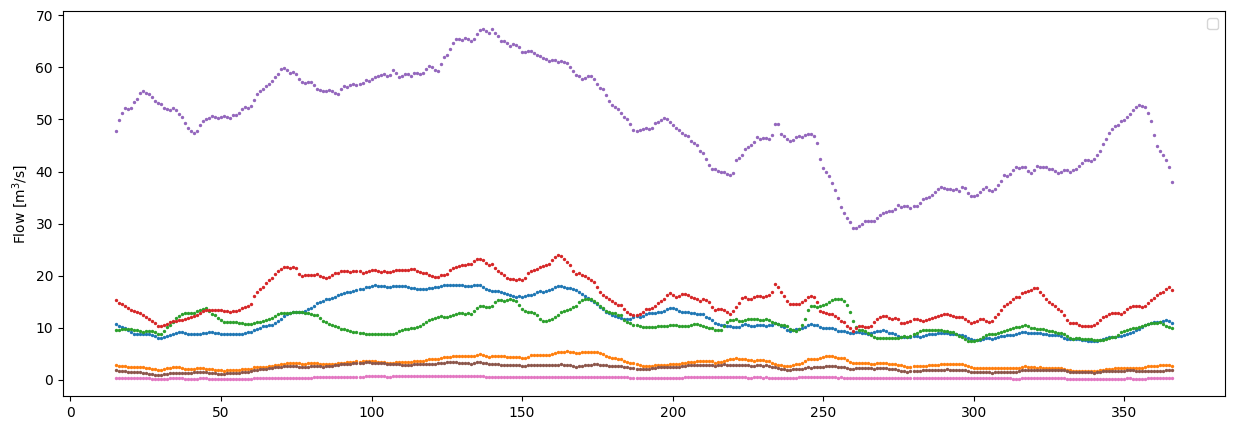

In [8]:
# plot all the stations flow data belonging to one cluster in one plot for 8 as number of cluste
import df_manipulation_functions as dfmf

num_clusters_plot = 6
flow_temp_df = pd.read_pickle("Data/flow_temp_df.pkl")

cluster_labels_kmeans_additional.head()

for i in range(0,num_clusters_plot):
    belonging_to_cluster = cluster_labels_kmeans_additional[cluster_labels_kmeans_additional[str(num_clusters_plot) + ' clusters'] == i]
    station_numbers = belonging_to_cluster['Stationsnummer']
    labels = list()
    plt.figure(figsize=(15,5))
    #set scale of y axis to be the same for all plots
    for station in station_numbers:
        station_data = dfmf.get_running_mean_df(station, 15, flow_temp_df, 'Flow_Wert')
        plt.scatter(station_data.index, station_data['Flow_Wert'], s=2)
        station_data['mean'] = station_data['Flow_Wert'].mean()
        #plt.plot(station_data.index, station_data['mean'])
        #add to each curve the number and name of the station
    #     station_name = flow_temp_df.loc[flow_temp_df['Stationsnummer'] == station]['Stationsname'].unique()[0]
    #     labels.append(str(station)+ " " + station_name)       
    # plt.xlabel('Day of the year')
    plt.ylabel('Flow [m$^3$/s]')
    plt.legend(labels)

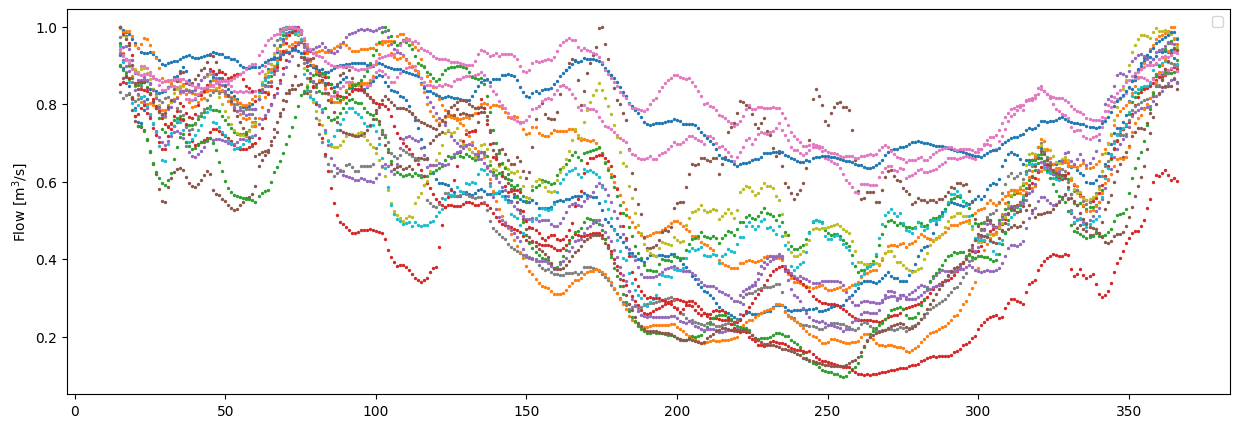

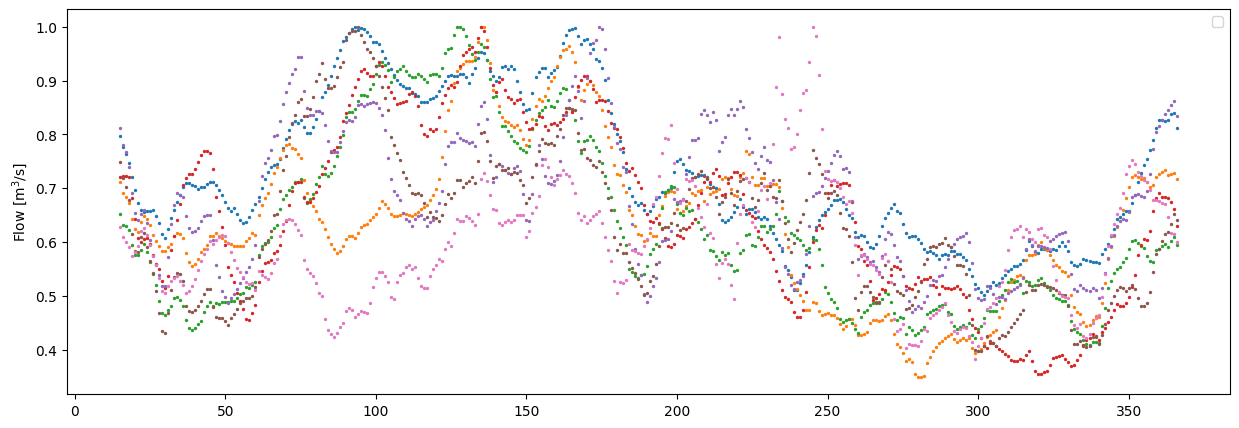

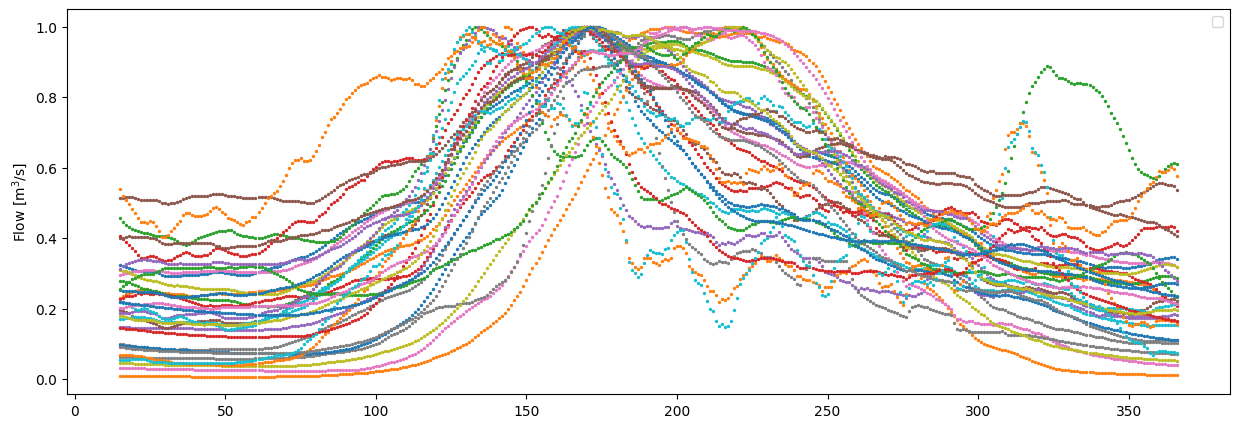

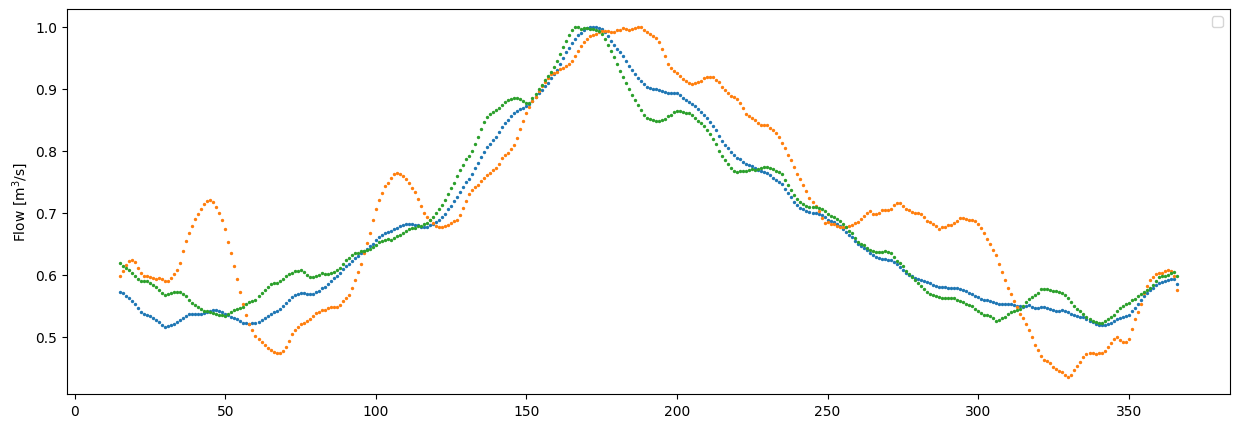

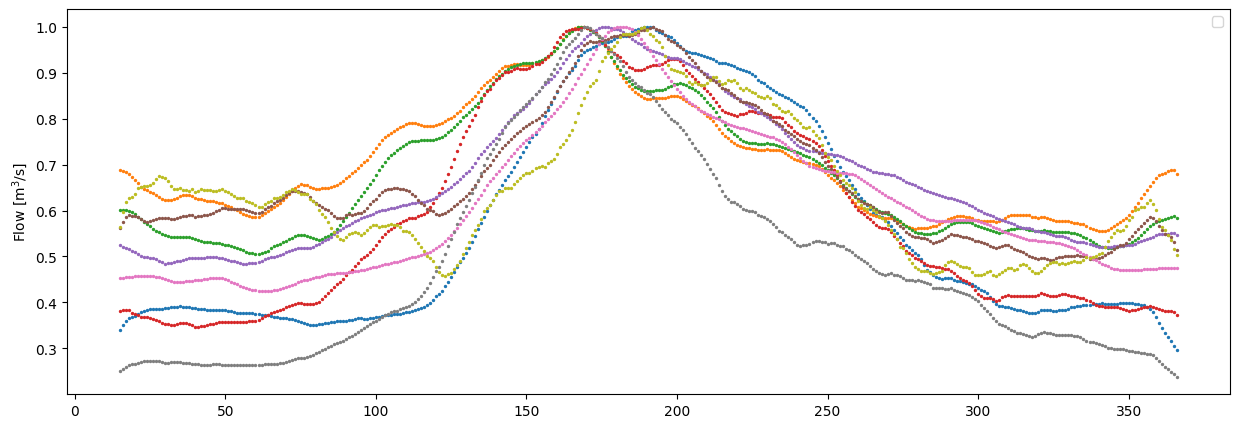

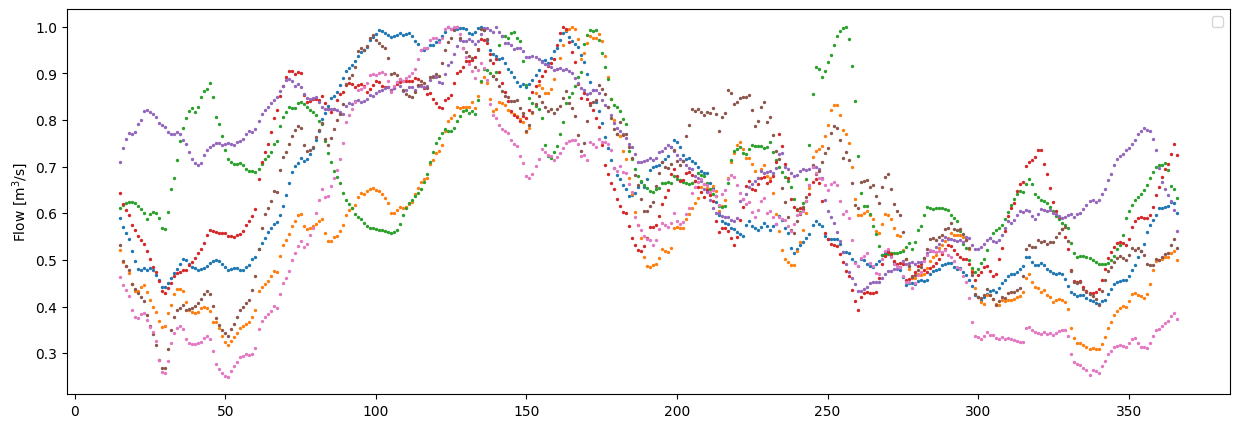

In [9]:
# plot all the stations flow data belonging to one cluster in one plot for 8 as number of cluste
import df_manipulation_functions as dfmf

num_clusters_plot = 6
flow_temp_df = pd.read_pickle("Data/flow_temp_df.pkl")

cluster_labels_kmeans_additional.head()

for i in range(0,num_clusters_plot):
    belonging_to_cluster = cluster_labels_kmeans_additional[cluster_labels_kmeans_additional[str(num_clusters_plot) + ' clusters'] == i]
    station_numbers = belonging_to_cluster['Stationsnummer']
    labels = list()
    plt.figure(figsize=(15,5))
    #set scale of y axis to be the same for all plots
    for station in station_numbers:
        station_data = dfmf.get_running_mean_df(station, 15, flow_temp_df, 'Flow_Wert')
        plt.scatter(station_data.index, station_data['Flow_Wert']/np.max(station_data['Flow_Wert']), s=2)
        station_data['mean'] = station_data['Flow_Wert'].mean()
        #plt.plot(station_data.index, station_data['mean'])
        #add to each curve the number and name of the station
    #     station_name = flow_temp_df.loc[flow_temp_df['Stationsnummer'] == station]['Stationsname'].unique()[0]
    #     labels.append(str(station)+ " " + station_name)       
    # plt.xlabel('Day of the year')
    plt.ylabel('Flow [m$^3$/s]')
    plt.legend(labels)